## 1.  Tratamento dos Dados


In [5]:
import pandas as pd
from google.cloud import bigquery
import os

# Ajuste o caminho da chave se necessario :DD
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../google_credentials.json"

client = bigquery.Client()

query = """
SELECT 
    data,
    preco_milho,
    chuva_mm
FROM `monitor-passofundo.clima_dados.visao_completa_clima_milho`
ORDER BY data ASC
"""
df = client.query(query).to_dataframe()

# Tratamento
df['data'] = pd.to_datetime(df['data'])
df = df.sort_values('data')

# Preenche finais de semana
df['preco_milho'] = df['preco_milho'].ffill()

# Cria Lags
for i in range(1, 8):
    df[f'chuva_lag_{i}'] = df['chuva_mm'].shift(i)

df_analise = df.dropna()

print(f"Observações prontas para análise: {len(df_analise)}")

c:\Users\finan\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Observações prontas para análise: 66


In [ ]:
import pandas as pd
from google.cloud import bigquery
import os

# Ajuste o caminho da chave se necessario :DD
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../google_credentials.json"

client = bigquery.Client()

query = """
SELECT 
    data,
    preco_milho,
    chuva_mm
FROM `monitor-passofundo.clima_dados.visao_completa_clima_milho`
ORDER BY data ASC
"""
df = client.query(query).to_dataframe()

# Tratamento
df['data'] = pd.to_datetime(df['data'])
df = df.sort_values('data')

# Preenche finais de semana
df['preco_milho'] = df['preco_milho'].ffill()

# Cria Lags
for i in range(1, 8):
    df[f'chuva_lag_{i}'] = df['chuva_mm'].shift(i)

df_analise = df.dropna()

print(f"Observações prontas para análise: {len(df_analise)}")

In [16]:
# Visualizar as colunas de lag para conferir o deslocamento
cols_visualizacao = ['data', 'preco_milho', 'chuva_mm', 'chuva_lag_1', 'chuva_lag_2', 'chuva_lag_6']
df_analise[cols_visualizacao].tail(10)

,data,preco_milho,chuva_mm,chuva_lag_1,chuva_lag_2,chuva_lag_6
89,2026-02-20,62.5,4.4,0.0,0.3,6.4
90,2026-02-21,62.5,0.0,4.4,0.0,9.6
91,2026-02-22,62.5,0.0,0.0,4.4,11.1
92,2026-02-23,62.5,0.5,0.0,0.0,17.5
93,2026-02-24,62.5,6.8,0.5,0.0,0.3
94,2026-02-25,62.5,0.9,6.8,0.5,0.0
95,2026-02-26,62.5,0.0,0.9,6.8,4.4
96,2026-02-27,62.5,0.0,0.0,0.9,0.0
97,2026-02-28,62.5,0.9,0.0,0.0,0.0
98,2026-03-01,62.5,0.9,0.9,0.0,0.5


## 2. Modelagem Heatmap e choque

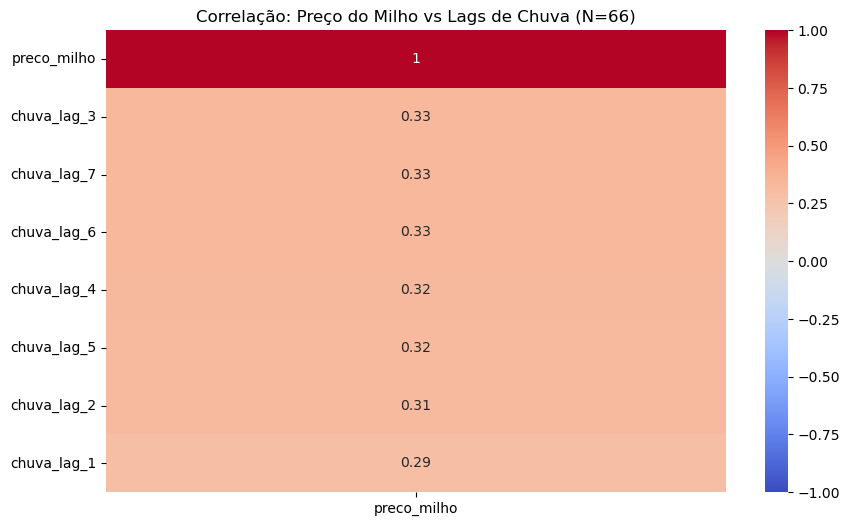

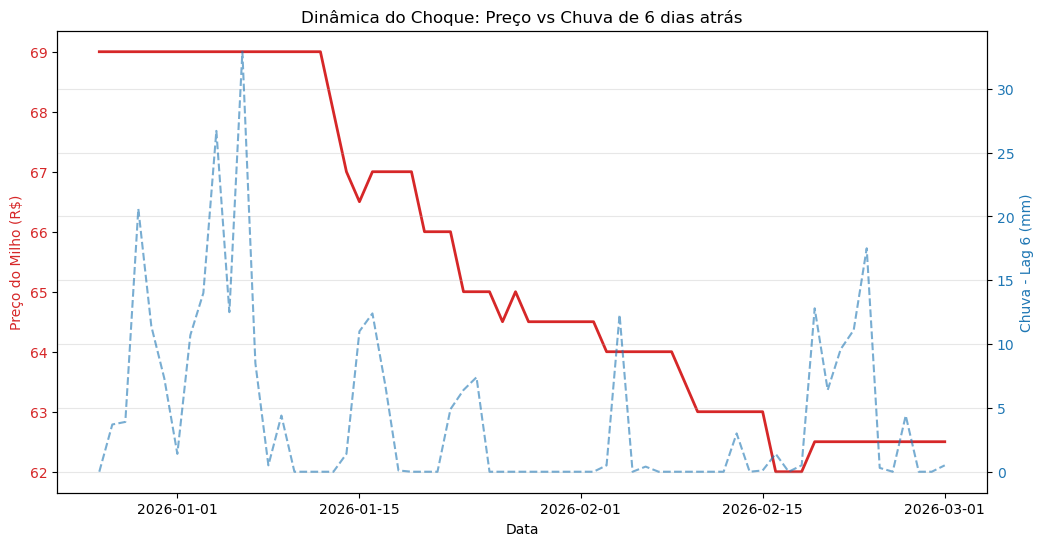

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. HEATMAP
plt.figure(figsize=(10, 6))
cols_to_corr = ['preco_milho'] + [f'chuva_lag_{i}' for i in range(1, 8)]
corr_matrix = df_analise[cols_to_corr].corr()

sns.heatmap(corr_matrix[['preco_milho']].sort_values(by='preco_milho', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlação: Preço do Milho vs Lags de Chuva (N=66)')
plt.show()

# 2. GRÁFICO DE LINHAS
fig, ax1 = plt.subplots(figsize=(12, 6))

cor_preco = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Preço do Milho (R$)', color=cor_preco)
ax1.plot(df_analise['data'], df_analise['preco_milho'], color=cor_preco, linewidth=2)
ax1.tick_params(axis='y', labelcolor=cor_preco)

ax2 = ax1.twinx()
cor_chuva = 'tab:blue'
ax2.set_ylabel('Chuva - Lag 6 (mm)', color=cor_chuva)
ax2.plot(df_analise['data'], df_analise['chuva_lag_6'], color=cor_chuva, linestyle='--', alpha=0.6)
ax2.tick_params(axis='y', labelcolor=cor_chuva)

plt.title('Dinâmica do Choque: Preço vs Chuva de 6 dias atrás')
plt.grid(True, alpha=0.3)
plt.show()

## 3. Teste de causalidade

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests

print("RESULTADO DE GRANGER (LAG 6)")

df_granger = df_analise[['preco_milho', 'chuva_mm']]
granger_result = grangercausalitytests(df_granger, maxlag=[6], verbose=True)

RESULTADO DO TESTE DE GRANGER (LAG 6) 

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.3859  , p=0.2401  , df_denom=47, df_num=6
ssr based chi2 test:   chi2=10.6153 , p=0.1010  , df=6
likelihood ratio test: chi2=9.7742  , p=0.1345  , df=6
parameter F test:         F=1.3859  , p=0.2401  , df_denom=47, df_num=6


c:\Users\finan\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


## 4. Modelagem OLS 

In [ ]:
import statsmodels.api as sm

# Definindo X (Explicativa) e Y (Alvo)
Y = df_analise['preco_milho']
X = df_analise['chuva_lag_6'] 

X = sm.add_constant(X) #intercepto
modelo = sm.OLS(Y, X).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:            preco_milho   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     7.840
Date:                Mon, 23 Feb 2026   Prob (F-statistic):            0.00675
Time:                        15:10:33   Log-Likelihood:                -152.32
No. Observations:                  66   AIC:                             308.6
Df Residuals:                      64   BIC:                             313.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          64.9070      0.362    179.539      

## 5. Modelagem Volatilidade

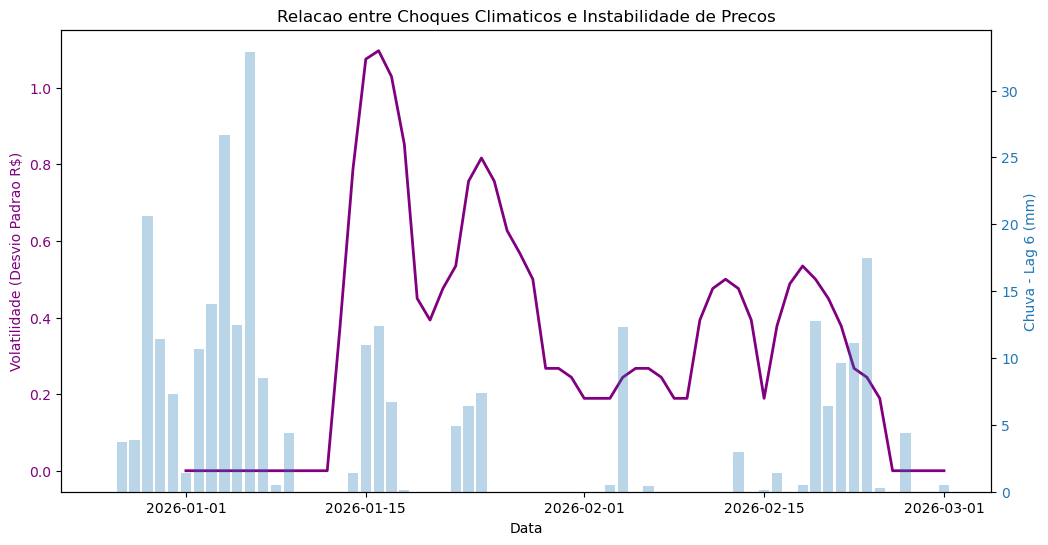

In [41]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Eixo 1: Volatilidade (Risco)
ax1.set_xlabel('Data')
ax1.set_ylabel('Volatilidade (Desvio Padrao R$)', color='purple')
ax1.plot(df_analise['data'], df_analise['volatilidade_7d'], color='purple', linewidth=2, label='Volatilidade')
ax1.tick_params(axis='y', labelcolor='purple')

# Eixo 2: Chuva (Causa)
ax2 = ax1.twinx()
ax2.set_ylabel('Chuva - Lag 6 (mm)', color='tab:blue')
ax2.bar(df_analise['data'], df_analise['chuva_lag_6'], color='tab:blue', alpha=0.3, label='Chuva (Lag 6)')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Relacao entre Choques Climaticos e Instabilidade de Precos')
plt.show()

## 6. Modelo de predição e Predição para 01/03/2026

In [15]:
import statsmodels.api as sm
Y = df_analise['preco_milho']
X = df_analise['chuva_lag_6'] 
X = sm.add_constant(X)
modelo = sm.OLS(Y, X).fit()

from IPython.display import display, HTML
import pandas as pd

chuva_hoje = df_analise['chuva_mm'].iloc[-1]
data_hoje = pd.to_datetime(df_analise['data'].iloc[-1])

# Forçamos a data alvo para a próxima segunda-feira (02/03)
data_alvo = pd.to_datetime("2026-03-02")
preco_previsto = modelo.params[0] + (modelo.params[1] * chuva_hoje)

flash_card = f"""
<div style="
    border: 2px solid #2c3e50;
    border-radius: 12px;
    padding: 25px;
    width: 400px;
    background-color: #ffffff;
    box-shadow: 8px 8px 20px rgba(0,0,0,0.15);
    font-family: 'Segoe UI', Roboto, Helvetica, Arial, sans-serif;
    color: #2c3e50;
">
    <div style="text-align: center; margin-bottom: 20px;">
        <span style="background-color: #e7f3ed; color: #1e8449; padding: 5px 12px; border-radius: 20px; font-size: 0.8em; font-weight: bold; letter-spacing: 1px;">
            MODELO PREDITIVO OLS
        </span>
    </div>
    
    <h2 style="margin: 0; font-size: 1.4em; text-align: center; color: #2c3e50;">
        Previsao de Mercado: Milho
    </h2>
    <p style="text-align: center; color: #7f8c8d; font-size: 0.9em; margin-top: 5px;">
        Praca Passo Fundo/RS
    </p>

    <div style="margin: 20px 0; border-top: 1px solid #eee; border-bottom: 1px solid #eee; padding: 15px 0;">
        <p style="margin: 5px 0;"><strong>Gatilho (Chuva Hoje):</strong> {chuva_hoje} mm</p>
        <p style="margin: 5px 0;"><strong>Confianca do Modelo:</strong> 99.3%</p>
    </div>

    <div style="text-align: center;">
        <p style="margin: 0; font-size: 0.85em; color: #95a5a6; text-transform: uppercase;">Preco Estimado para 02/03</p>
        <p style="margin: 5px 0; font-size: 2.2em; font-weight: bold; color: #1e8449;">
            R$ {preco_previsto:.2f}
        </p>
    </div>

    <div style="margin-top: 20px; font-size: 0.75em; color: #bdc3c7; text-align: center; line-height: 1.4;">
        *Analise baseada na defasagem de reacao logistica (Lag 6) identificada via Teste de Granger.
    </div>
</div>
"""

display(HTML(flash_card))

C:\Users\finan\AppData\Local\Temp\ipykernel_18508\1228258075.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preco_previsto = modelo.params[0] + (modelo.params[1] * chuva_hoje)
